In [1]:
from netCDF4 import Dataset
from rasterio import Affine as A
import numpy as np
from os import listdir, makedirs
from os.path import isfile, join, basename, exists
import xarray
from skimage.measure import block_reduce
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [2]:
# input the directory and the program will parse all netcdf geodata
dir_path = input("[*] Please enter the directory path to the file: ")
save_folder_path = join(dir_path, "upscale")
gfed5_variable_names = ["Crop", "Defo", "Peat", "Total", "Nat"]
files =  [
    join(dir_path, file)
    for file in listdir(dir_path)
    if isfile(join(dir_path, file))
    and (file.split(".")[-1] == "hdf5" or file.split(".")[-1] == "nc")
]

In [3]:
def upscale_matrix_numpy(source_matrix, window_height = 8, window_width = 10):
    """
    Function preforms the process of upscaling the passed in matrix using numpy or skimage
    (first determining if this is possible and then preforming the operation)
    
    :param source_matrix: matrix we wish to compress (upscale)
    :param window_height: height of the window we wish to iterate over with
    :param window_width: width of the window we wish to iterate over with
    :return: upscaled matrix
    """
    
    try:
        source_shape = source_matrix.shape   
        # check if the window size lines up evenly with the passed in matrix
        if (source_shape[0] % window_height == 0) and (source_shape[1] % window_width == 0):
            # This is another method to reduce a matrix with a window using a sum calculation (both work the same)
            # downscaled_data = block_reduce(source_matrix, block_size=(window_height, window_width), func=np.sum)
            # reshape the matrix into a 4D matrix (shows each window of the matrix)
            reshape_result = source_matrix.reshape(source_shape[0] // window_height, window_height, source_shape[1] // window_width, window_width)
            # sum the windows and creates the 2D matrix
            result = reshape_result.sum(axis=(1, 3))
            print("[+] Successfully upscaled matrix, current updated matrix shape: ", np.asarray(result).shape)
            return result
    except Exception as error:
        print("[-] Failed to upscale matrix", error)
        return source_matrix

In [4]:
def evaluate_upscale_sum(origin_matrix, upscaled_matrix, margin_of_error = 65536.0):
    """
    Function prints our the original matrix sum and the upscaled matrix sum (post re grid)
    It then determines if the upscaled matrix sum is close enough to the original matrix sum (incorporating a margin of error)
    
    :param origin_matrix: original matrix before re grid
    :param upscaled_matrix: the original matrix post re grid
    :param margin_of_error: the margin of error the allowed 
    :return: boolean
    """
    print()
    print(f"Original Burned Area Total - {origin_matrix.sum()}")
    print(f"\tOriginal Burned Area Dimensions - {origin_matrix.shape}")
    print(f"Upscale Burned Area Total - {upscaled_matrix.sum()}")
    print(f"\tUpscale Burned Area Dimensions - {upscaled_matrix.shape}")
    print()
    
    # returns true if the upscaled matrix sum is within the range of the original matrix sum (margin of error accounts for rounding of values)
    return upscaled_matrix.sum() >= (origin_matrix.sum() - margin_of_error) and origin_matrix.sum() <= (origin_matrix.sum() + margin_of_error)
    

In [5]:
def obtain_new_filename(file_path) -> str:
    # creates a file name (adding upscale to the current file name)
    file_name = basename(file_path)
    file_name_list = file_name.split(".")
    if len(file_name_list) > 1:
        file_name_list[-2] = file_name_list[-2] + "(upscaled)"
        # ensures the file is saved as a netcdf file
        file_name_list[-1] = "nc"
        # return the rejoined list and the added classes save folder path
        return join(save_folder_path, ".".join(file_name_list))
    return join(save_folder_path, file_name)

In [6]:
def save_file(file_path, data_set) -> None:
    """
    Saves the xarray dataset based on the file inputted to the function

    :param file_path: file path of the current file being upscaled/processed
    :param data_set: data set representing the
    :return: None
    """
    try:
        # create the new file's path & name
        new_file_name = obtain_new_filename(file_path)
        # checks if the save folder path exists (if it does not a folder is created)
        if not exists(save_folder_path):
            makedirs(save_folder_path)
        # saves the file using the created file path and xarray
        data_set.to_netcdf(path=(new_file_name))
        print(f"[+] file {new_file_name} saved")
    except Exception as error:
        print(
            "[-] Failed to save dataset (ensure dataset is from xarray lib): ",
            error,
        )

In [7]:
def plot_geodata(origin_matrix, upscaled_matrix, longitude, latitude) -> None:
    """
    Saves the xarray dataset based on the file inputted to the function
    
    :param file_path: file path of the current file being upscaled/processed 
    :param data_set: data set representing the 
    :return: None
    """
    # map = Basemap(projection='merc',llcrnrlon=-90.,llcrnrlat=90.,urcrnrlon=-180.,urcrnrlat=180.,resolution='i') # projection, lat/lon extents and resolution of polygons to draw
    # lon, lat = np.meshgrid(longitude, latitude)
    # xi, yi = map(lon, lat)
    # resolutions: c - crude, l - low, i - intermediate, h - high, f - full
    plt.imshow(origin_matrix, interpolation='none')
    plt.show()
    
    plt.imshow(upscaled_matrix, interpolation='none')
    plt.show()
    pass

In [8]:
"""
loops through each file in the classes files list Regridding (upscaling) datasets from a fine resolution to a coarse (ModelE) resolution
Note - This is focused on the burned area dataset and uses both netcdf (parsing/reading) and xarray (saving the data)
    Issue (SOLVED) - When saving the dataset the unscaled burned area is classified as a 2D variable instead of a Geo2D variable

:param: None
:return: None
"""
def upscale_data_type_x():
    for file in files:
        try:
            with Dataset(file) as netcdf_dataset:
                # dataset containing all xarray data array (used to create the final netcdf file)
                dataset_dict = {}
                
                # obtain the grid cell area value (allows for the burned area to account for the shape of the earth)
                grid_cell_area_value = netcdf_dataset.groups["ancill"].variables["grid_cell_area"][:]
                
                # loop through every burned area month
                for group in netcdf_dataset.groups["burned_area"].groups:
                    #obtain the current burned area group
                    burned_area_group = netcdf_dataset.groups["burned_area"].groups[group]
                    
                    # obtain the burned_area fraction array for the current month/group we are in
                    burned_area_fraction = burned_area_group.variables["burned_fraction"]
                    burned_area_fraction_value = burned_area_fraction[:]
                    
                    # multiplying the grid cell area by the burned fraction value
                    burned_fraction_product = grid_cell_area_value * burned_area_fraction_value
                    burned_fraction_product = np.asarray(burned_fraction_product)
                                            
                    # upscale the burned fraction
                    burned_fraction_upscaled = upscale_matrix_numpy(burned_fraction_product)
                    
                    # Total of orig resolution after multiplying by gridcell area should be equal to total of final (target) resolution. Both are in m^2.
                    if evaluate_upscale_sum(burned_fraction_product, burned_fraction_upscaled):
                        burnded_area_attribute_dict = {}
                        
                        # Copy attributes of the burned area fraction
                        for attr_name in burned_area_fraction.ncattrs():
                            burnded_area_attribute_dict[attr_name] = getattr(burned_area_fraction, attr_name)
                            
                        # update the units to match the upscaling process
                        burnded_area_attribute_dict["units"] = "m^2"
                        
                        # obtain the height and width from the upscale shape 
                        # create an evenly spaced array representing the longitude and the latitude
                        height, width = burned_fraction_upscaled.shape
                        latitudes = np.linspace(-90, 90, height)  
                        longitudes = np.linspace(-180, 180, width) 
                        
                        #plots the burned area before and after the rescale
                        plot_geodata(burned_fraction_product, burned_fraction_upscaled, longitudes, latitudes)
                        # flip the data matrix (upside down due to the GFED dataset's orientation)
                        burned_fraction_upscaled = np.flip(burned_fraction_upscaled, 0)
                        
                        # create the xarray data array for the upscaled burned area and add it to the dictionary
                        burned_area_data_array = xarray.DataArray(burned_fraction_upscaled, coords={'latitude': latitudes, 'longitude': longitudes}, dims=['latitude', 'longitude'], attrs=burnded_area_attribute_dict)
                        dataset_dict[f"burned_areas_{group}"] = burned_area_data_array

                # saves xarray dataset to a file
                save_file(file, xarray.Dataset(dataset_dict))
        except Exception as error:
            print("[-] Failed to parse dataset: ", error)
        

In [9]:
def upscale_data_type_y() -> None:
    """
    loops through each file in the classes files list Regridding (upscaling) datasets from a fine resolution to a coarse (ModelE) resolution
    Note - This is focused on the burned area dataset and uses both netcdf (parsing/reading) and xarray (saving the data)
        Issue (SOLVED) - When saving the dataset the unscaled burned area is classified as a 2D variable instead of a Geo2D variable

    :param: None
    :return: None
    """
    for file in files:
        try:
            with Dataset(file) as netcdf_dataset:
                # dataset containing all xarray data array (used to create the final netcdf file)
                dataset_dict = {}

                for variable_name in gfed5_variable_names:
                    match variable_name:
                        # calculates the Nat array
                        case "Nat":
                            # transform the arrays dimensions to (720, 1440) and convert (km^2 -> m^2)
                            # obtain all needed data array
                            var_total_data_array = netcdf_dataset.variables[
                                "Total"
                            ][:][0] * (10**6)
                            var_crop_data_array = netcdf_dataset.variables["Crop"][
                                :
                            ][0] * (10**6)
                            var_defo_data_array = netcdf_dataset.variables["Defo"][
                                :
                            ][0] * (10**6)
                            var_peat_data_array = netcdf_dataset.variables["Peat"][
                                :
                            ][0] * (10**6)
                            # calculate the Nat numpy array
                            # equation: Total - (Crop + Defo + Peat)
                            var_data_array = var_total_data_array - (
                                var_crop_data_array
                                + var_defo_data_array
                                + var_peat_data_array
                            )
                        # base case
                        case _:
                            # obtain the variables in the netcdf_dataset
                            # dimensions (1, 720, 1440)
                            var_data = netcdf_dataset.variables[variable_name]

                            # obtain the numpy array for each netcdf variable
                            # transform the arrays dimensions to (720, 1440) and convert the metric to km^2 -> m^2
                            var_data_array = var_data[:][0] * (10**6)

                    # preform resampling/upscaling (upscaling on all the variable numpy array)
                    # Conversion (720, 1440) -> (90, 144)
                    upscaled_var_data_array = upscale_matrix_numpy(
                        var_data_array
                    )

                    if evaluate_upscale_sum(
                        var_data_array, upscaled_var_data_array
                    ):
                        attribute_dict = {}

                        # Copy attributes of the burned area fraction
                        for attr_name in var_data.ncattrs():
                            attribute_dict[attr_name] = getattr(var_data, attr_name)

                        # update the units to match the upscaling process
                        attribute_dict["units"] = "m^2"

                        # obtain the height and width from the upscale shape
                        # create an evenly spaced array representing the longitude and the latitude
                        height, width = upscaled_var_data_array.shape
                        latitudes = np.linspace(-90, 90, height)
                        longitudes = np.linspace(-180, 180, width)

                        #plots the burned area before and after the rescale
                        plot_geodata(var_data_array, upscaled_var_data_array, longitudes, latitudes)

                        # create the xarray data array for the upscaled burned area and add it to the dictionary
                        burned_area_data_array = xarray.DataArray(
                            upscaled_var_data_array,
                            coords={"latitude": latitudes, "longitude": longitudes},
                            dims=["latitude", "longitude"],
                            attrs=attribute_dict,
                        )
                        dataset_dict[variable_name] = burned_area_data_array

                # saves xarray dataset to a file
                save_file(file, xarray.Dataset(dataset_dict))
        except Exception as error:
            print("[-] Failed to parse dataset: ", error)


[+] Successfully upscaled matrix, current updated matrix shape:  (90, 144)

Original Burned Area Total - 92654598942.20728
	Original Burned Area Dimensions - (720, 1440)
Upscale Burned Area Total - 92654598942.2073
	Upscale Burned Area Dimensions - (90, 144)



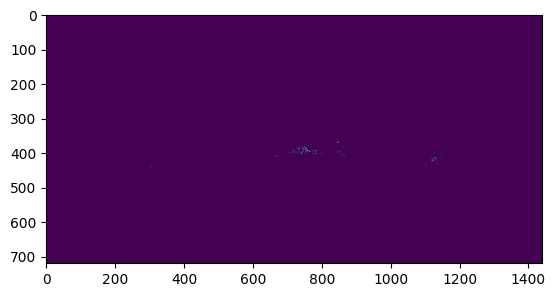

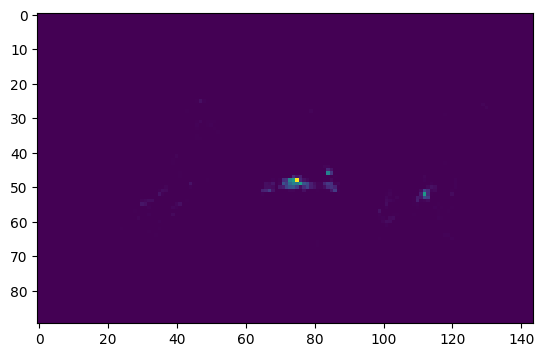

[+] Successfully upscaled matrix, current updated matrix shape:  (90, 144)

Original Burned Area Total - 482162803.3225368
	Original Burned Area Dimensions - (720, 1440)
Upscale Burned Area Total - 482162803.3225367
	Upscale Burned Area Dimensions - (90, 144)



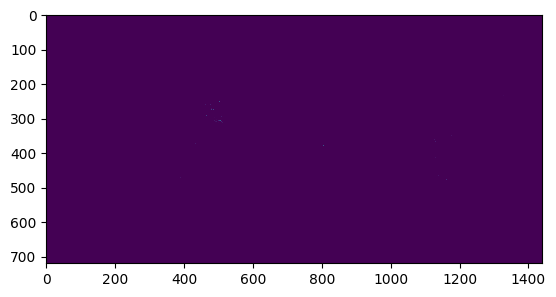

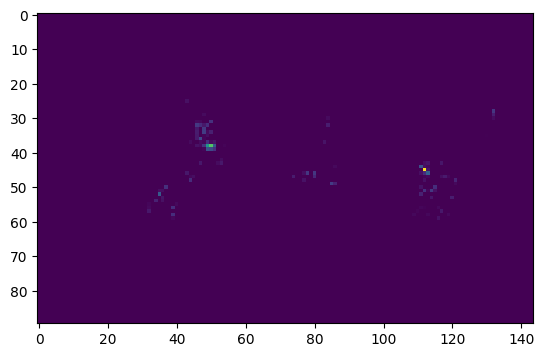

[+] Successfully upscaled matrix, current updated matrix shape:  (90, 144)

Original Burned Area Total - 2709221157.497648
	Original Burned Area Dimensions - (720, 1440)
Upscale Burned Area Total - 2709221157.4976482
	Upscale Burned Area Dimensions - (90, 144)



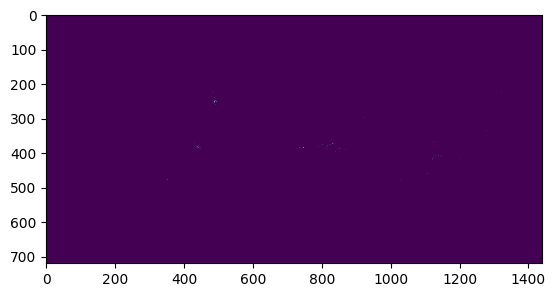

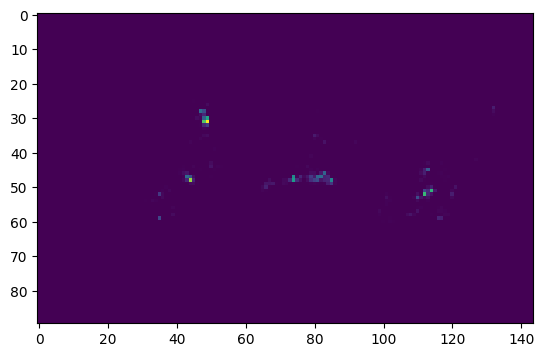

[+] Successfully upscaled matrix, current updated matrix shape:  (90, 144)

Original Burned Area Total - 910463066158.4922
	Original Burned Area Dimensions - (720, 1440)
Upscale Burned Area Total - 910463066158.4922
	Upscale Burned Area Dimensions - (90, 144)



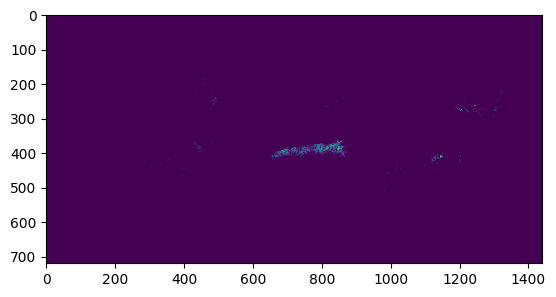

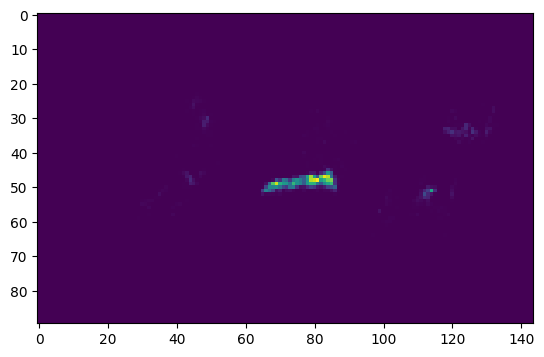

[+] Successfully upscaled matrix, current updated matrix shape:  (90, 144)

Original Burned Area Total - 814617083255.4646
	Original Burned Area Dimensions - (720, 1440)
Upscale Burned Area Total - 814617083255.465
	Upscale Burned Area Dimensions - (90, 144)



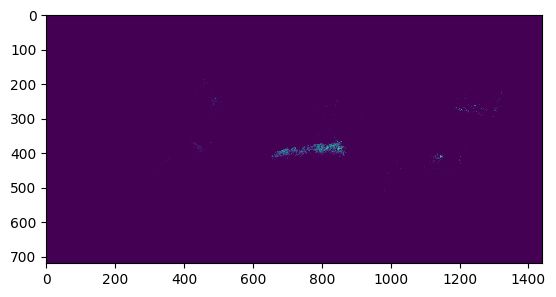

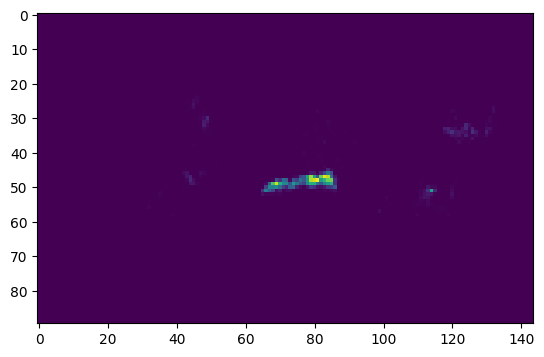

[+] file ./GFED5\upscale\BA200201(upscaled).nc saved


In [10]:
#upscale_data_type_x()
upscale_data_type_y()